# Sentiment Analysis using FastAI to fine tune a Language Model

### Steps in FastAI :
*  Data pre-processing
*  Create a language model, then fine-tune it to our dataset.
*  Create Sentiment Analysis Classifier on top of the language model.

##### Data Source : IMDB dataset 25,000 movie reviews for training, and 25,000 for testing

In [0]:
import fastai
import pandas as pd

In [0]:
from fastai.text import *

In [0]:
df_imdb = pd.read_csv('/home/movie_data.csv')

In [60]:
df_imdb.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


In [61]:
len(df_imdb)

50000

In [62]:
df_imdb['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

We will use only 5000 [2500 each label] from Training and 3000 [1500 each label] from Validation dataset to finish the training faster

In [0]:
trn_texts = df_imdb.loc[10000:14999, 'review'].values
trn_labels = df_imdb.loc[10000:14999, 'sentiment'].values

In [0]:
val_texts = df_imdb.loc[36000:38999, 'review'].values
val_labels = df_imdb.loc[36000:38999, 'sentiment'].values

In [0]:
col_names = ['labels','text']

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)

In [0]:
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [68]:
df_trn['labels'].value_counts()

1    2500
0    2500
Name: labels, dtype: int64

In [69]:
df_val['labels'].value_counts()

1    1500
0    1500
Name: labels, dtype: int64

### Step 1: Data Preprocessing

* Use TextLMDataBunch to create a language model specific data bunch which does all the preprocessing

In [70]:
data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [71]:
data_lm.show_batch()

idx,text
0,"breath of fresh air in a world ridden with repetitive anime series and non innovative xxup tv shows . \n \n xxmaj characters are well developed , and you will end up loving them , some less than others . xxmaj the word to describe the animation job does not exist , since "" excellent "" would really fall short to describe how was done . xxmaj there are"
1,"results . a lot of people are mad . xxmaj mad because it does n't have the best special effects . xxmaj mad because it does n't have a star cast . xxmaj mad because they wanted to see xxmaj samuel xxmaj jackson say "" i 'm sick of these m^*&*&%-er f*^(^%-ing xxmaj snakes on this m^*&*&%-er f*^(^%-ing xxmaj train "" ! \n \n xxmaj well , this sure"
2,", 8 / 10 . xxbos "" xxmaj joe "" is one of those movies where , although you think that it might go along smoothly , ends up hitting you like ... i ca n't come up with an analogy . xxmaj it showed not only that xxmaj america 's long - standing idea of unity was moot , but also the various aspects within our society . xxmaj"
3,"of a film on death and remembrance . ( xxmaj and possibly hope for the xxunk , i think ... ) \n \n i highly recommend this film to anybody who has deep interest in film art as well as xxmaj korean culture . xxmaj this film , in my opinion , can be rivaled with other movies like xxmaj tokyo story , and a sort of xxmaj american"
4,park series ) are entertaining and probably ( as is much else on this release ) a reason for obtaining this disc alone for anyone remotely interested in the work of these two characters . xxmaj loaded with much more than i could mention here ( including a xxup second audio - commentary ) this is one of the best xxmaj troma - xxup dvd - releases . xxbos xxmaj


### FastAI Special Tags 
* xxbos: Begining of a sentence
* xxfld: Represent separate parts of a document like title, summary etc
* xxup: Capital words gets lower cased and a token (xxup) is added to it
* xxunk: token used instead of an uncommon word
* xxmaj: token indicates that there is capitalization of the word
* xxrep: token indicates repeated word

Vocabulary: List of unique possible tokens is called the vocabulary

Listing below first 20 unique tokens in order of frequency:

In [72]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'a',
 'and',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

* Numericalization: Replace the tokens with the location of the token in the vocab:

The default vocab size is set to 60,000 words and minimum count for a word to be added to vocab is 2, to avoid getting the weight matrix huge

* Save and Load: We can save the data bunch after the pre-processing is done. 
* We can load as well whenever we need

In [0]:
data_lm.save('tmp_lm')

## Step 2: Create Language Model

* Language model fine-tuning

* We use the pre-trained language model weights and fine-tune it with the training data of IMDb movie reviews.

In [74]:
learner = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)

* Search through a range of learning rates to find the optimum one for our dataset

In [75]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


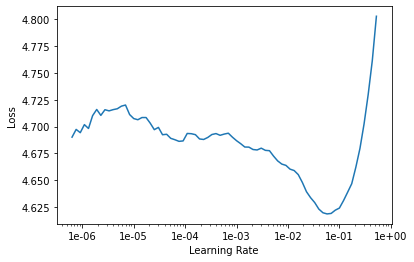

In [87]:
learner.recorder.plot(skip_end=15)

* Training the model with learning rate 1e-2 using fit_one_cycle

In [88]:
learner.fit_one_cycle(1, 1e-2) 

epoch,train_loss,valid_loss,accuracy,time
0,4.245914,4.005554,0.286548,02:56


In [0]:
learner.save('fit_head')

From above, We get an accuracy of 28% after running just one epoch.

* Our model so far trained only the last layers and basically left most of the model exactly as it was
* What we really want is to finetune and train the whole model
* To complete the fine-tuning, we unfreeze and launch a new training

In [0]:
learner.unfreeze()

In [92]:
learner.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.589197,3.908929,0.296117,03:27
1,3.415349,3.893844,0.299392,03:27


In [0]:
learner.save('fine_tuned_model')

* Let's save the encoder which is responsible for creating and updating the hidden state and will then be used for Classification

In [0]:
learner.save_encoder('fine_tuned_encoder')

## Step 3 : Create Classifier

* Create a data bunch, TextClasDataBunch, passing the vocab from the language model to make sure that it is going to have exactly the same vocab

In [96]:
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32) 

In [0]:
data_clas.save('data_clas.pkl')

In [97]:
data_clas.show_batch() 

text,target
"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that says : \n \n * xxup major xxup spoilers xxup ahead * \n \n ( but you already knew that , did n't you ? ) \n \n xxmaj since there 's a great deal of people that apparently did not get the point of this movie , i 'd like to contribute",1
"xxbos ' xxmaj the xxmaj merchant of xxmaj venice ' is one of xxmaj shakespeare 's better - known plays and is still regularly performed in the theatre . xxmaj incredibly , however , this film would seem to be the first - ever xxmaj english - language version made for the cinema rather than television . xxmaj there were a number of versions made in xxmaj britain or xxmaj",1
"xxbos xxmaj the xxmaj merchant of xxmaj venice 8 / 10 \n \n ( xxmaj this review assumes a basic knowledge of the story and so may be thought of as containing spoilers to anyone unfamiliar with the plot . ) \n \n xxmaj as a film version of the famous xxmaj shakespeare play , xxmaj merchant of xxmaj venice does what few adaptations have done since xxmaj",1
"xxbos "" xxmaj empire xxmaj strikes xxmaj back "" director xxmaj irvin xxmaj kershner 's "" xxmaj never xxmaj say xxmaj never xxmaj again , "" a remake of the 1965 xxmaj james xxmaj bond movie "" xxmaj thunderball , "" does n't surpasses the xxmaj terence xxmaj young original , but this non - xxmaj harry xxmaj saltzman & xxmaj albert xxup r. xxmaj broccoli film is well worth",1
"xxbos xxmaj years ago , when xxup darling xxup lili played on xxup tv , it was always the pan and scan version , which i hated and decided to wait and see the film in its proper widescreen format . xxmaj so when i saw an inexpensive xxup dvd of this xxmaj julie xxmaj andrews / xxmaj blake xxmaj edwards opus , i decided to purchase and watch it",0


* Create a text classifier learner by loading in our model alongwith the encoder

In [100]:
classifier = text_classifier_learner(data_clas, arch=AWD_LSTM ,drop_mult=0.5) 
classifier.load_encoder('fine_tuned_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5000 items)
x: TextList
xxbos i have no words to really describe this series . 
 
  xxmaj the premise behind this concept ( a highly hyperactive girl with a very eccentric personality which ends up whirling up a team of xxunk into her own rendering of the world , which after all was a creation of xxmaj haruhi , since she wants a world with aliens , espers and time travelers ) is a breath of fresh air in a world ridden with repetitive anime series and non innovative xxup tv shows . 
 
  xxmaj characters are well developed , and you will end up loving them , some less than others . xxmaj the word to describe the animation job does not exist , since " excellent " would really fall short to describe how was done . xxmaj there are many funny situations which either will make you smile or put you into deep thoughts . xxmaj do n't fall for the impression of the first episode , since that 's only the tip of the iceberg , as the novels are y

*  Find the learning rate

In [101]:
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


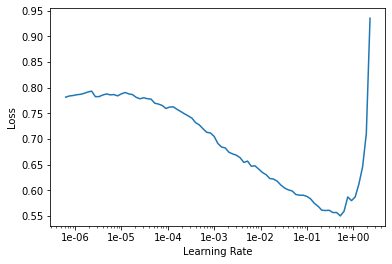

In [108]:
classifier.recorder.plot(skip_end=2)

In [109]:
classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.367220,0.328281,0.856000,02:18


From above, using Transfer Learning, we got 85% accuracy using only 5000 training and 3000 validation samples 

* Calculate Loss Plot while training the model:

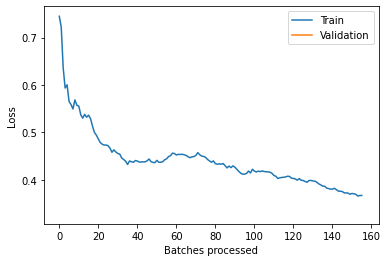

In [110]:
classifier.recorder.plot_losses()

In [0]:
classifier.save('first')

#### Further fine tuning

* To improve the accuracy further, fast.ai provides 'freeze_to' function 
* Let's unfreeze one layer at a time and check accuracy

* Unfreeze the last two layers freeze_to(-2), train it a little bit more

In [112]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,0.304642,0.277149,0.882333,02:31


In [0]:
classifier.save('second')

* Unfreeze the next layers freeze_to(-3), train it a little bit more

In [115]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.248328,0.245691,0.896333,03:19


In [0]:
classifier.save('third')

* Unfreeze the whole thing unfreeze(), train it a little bit more

In [117]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.181109,0.261311,0.885667,03:47


* Let us use our classifier and predict some movie review:

In [123]:
classifier.predict('The movie was awesome')

(Category tensor(1), tensor(1), tensor([0.0120, 0.9880]))

In [125]:
classifier.predict('The movie was not good')

(Category tensor(1), tensor(1), tensor([0.3041, 0.6959]))